# **_Introduction_**

###### In this project, my aim is to find the most efficient model describing the Mean Temperature of the day, given the past three days of weather measurements, current month, current day by using Madrid_Weather_1991_1995.csv. Since redundancy, lots of missing data in the dataset, I spent most of my time on the preprocessing of the data. At the latest stage of data-preprocessing, coming up with the most meaningful and best explaining features was aimed. Later on, bu trying different sets of models in regression, I fitted the most efficient 3 regressor models.

In [83]:
#importing required libraries
import pandas as pd  #pandas to handle with dataframes
import numpy as np   #numpy to handle with matrixes
from sklearn.model_selection import train_test_split  #used to split the dataframe to train and test
from sklearn.metrics import mean_squared_error, mean_absolute_error  #metrics to evaluate models
from sklearn.linear_model import LinearRegression #model of Linear Regression
from sklearn.svm import SVR  #model of Support Vector Regressor
from sklearn.ensemble import RandomForestRegressor #model of Random Forest Regressor
import matplotlib.pyplot as plt  #used for plots
from sklearn.pipeline import make_pipeline #used to make pipeline and utilize in short time
from sklearn.preprocessing import StandardScaler #used to scale the data to obtain more accuracy in the model

Reading csv file. I dropped the column "Maximum_Speed_Of_Wind" since the high amount of missing data which is unable to fill, I also dropped the indexing column due to unnecessity. In all dataframe, I replaced the values "-" with NaN to be able to play better with dataframe. Selecting "Average_Temperature" column as target dataframe. Then, I extracted the columns of month and day to play with them later.

In [84]:
df = pd.read_csv('Madrid_Weather_1991_1995.csv') #reading csv file of data
df = df.drop(axis = 1,  columns= ['Unnamed: 0', 'Maximum_Speed_Of_Wind']) #dropping column with so many missing data and index column
df = df.replace({'-': np.NaN}) #replacing "-" values with NaN
target = df["Average_Temperature"] #selecting "Average_Temperature" as target dataframe
month = df["Month"] #extracting columns of month 
day = df["Day"] #extracting columns of day 

When I was playing with the data computationally, I noticed that some values in data did not have type of number as floats or integers. So I decided to convert them all to numeric values. Other than "Maximum_Speed_Of_Wind" column, there were some other columns where high amount of missing data exist until a certain day. Determining that day -912. day-, then I extracted the whole data after 912. day. We now have almost half of the data, which is second half of the data.

In [85]:
df = df.apply(lambda x: pd.to_numeric(x, errors='ignore'), axis = 0)#assuring to have all data as numbers
df = df.iloc[912:, :].reset_index(drop=True) #getting the data after specific row
y = target.iloc[912:,] #getting the target after specific row
month = month.iloc[912:,] #getting the month column after specific row
day = day.iloc[912:,] #getting the day column after specific row

I now tried to find correlation values of all features. Printing the correlation values...

In [86]:
np.abs(df.corr())['Average_Temperature'] #printing the correlation values

Year                                                0.012787
Month                                               0.077874
Day                                                 0.027732
Average_Temperature                                 1.000000
Maximum_Temperature                                 0.971220
Minimum_Temperature                                 0.932868
Average_Pressure_Sea_Level                          0.513383
Average_Pressure_Station_Level                      0.258644
Average_Relative_Humidity                           0.734779
Total_Rainfall_Snowmelt                             0.050139
Average_Visibility                                  0.414876
Average_Wind_Speed                                  0.091562
Maximum_Sustained_Wind_Speed                        0.193178
Indicator_For_Occurrence_Of_Fog                     0.266166
Indicator_For_Occurrence_Of_Rain                    0.150057
Indicator_For_Occurrence_Of_Snow                    0.021951
Indicator_For_Occurrence

Having all correlation values, I dropped every features which have correlation value of less than 0.1 and more than 0.9. 

In [87]:
absed_corr = np.abs(df.corr()['Average_Temperature']) # getting the correlation values

#dropping every features which have correlation value of less than 0.1 and more than 0.9
cols_to_keep_df = pd.DataFrame((absed_corr <= 0.9) & (absed_corr >= 0.1)).reset_index()

# getting feature names to be kept
cols_to_keep_list = list(cols_to_keep_df[cols_to_keep_df['Average_Temperature'] == True]['index'])

Converting the dataframe into the one which has the intented features with proper correlation values. Then, I printed the general information about latest dataframe in order to see the number of null values and feature names.

In [88]:
df = df[cols_to_keep_list]#Converting the dataframe into the one which has the intented features with proper correlation values
df.info() #printing the general information about latest dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 914 entries, 0 to 913
Data columns (total 8 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Average_Pressure_Sea_Level           886 non-null    float64
 1   Average_Pressure_Station_Level       908 non-null    float64
 2   Average_Relative_Humidity            913 non-null    float64
 3   Average_Visibility                   914 non-null    float64
 4   Maximum_Sustained_Wind_Speed         911 non-null    float64
 5   Indicator_For_Occurrence_Of_Fog      914 non-null    int64  
 6   Indicator_For_Occurrence_Of_Rain     914 non-null    int64  
 7   Indicator_For_Occurrence_Of_Thunder  914 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 57.2 KB


I defined a function which fills the missing values with the mean value of closest two unmissing values. So that, we have a full dataframe having no missing values.

In [89]:
#This function simply fills each missing data with the mean value of two closest unmissed datas, 
#namely the one which comes before missing data, and the one coming after the missing data

def nanfiller(df): #function which fills the missing values
    for column in list(df.columns):
        nan_index_list = []
        nan_index_list.append((df[column].index[(df[column].isna())]).astype(np.int32))# index of NaN values in each column
        #nan_index_list is index list
        for index in nan_index_list:
            for indexx in index.values:
                temp = 1
                assign_mean = [indexx]
                while True:
                    index = list(index)
                    if indexx + temp in index:
                        assign_mean.append(indexx + temp)
                        index.remove(indexx + temp)
                        temp += 1
                    else:
                        value = (df.loc[indexx - 1, column] + df.loc[indexx + temp, column])/2 #finding mean value
                        df.loc[assign_mean, column] = value #the operation changing the missing value
                        break
    return df
df = nanfiller(df) #converting to have no NaN value in my dataframe


Now, in order to achive the purpose explained in the document on Ninova, predicting the Mean Temperature for the day, given the past three days of weather measurements, current month, current day- I write the script below.
At latest stage of this script, in X data, I have the weather measurements of day-1, day-2, day-3 and the current month and day of day-0. In Y data, I have the Mean Temperature for the day-0.

In [90]:
x_to_convert_df = [] #holder list for X data
y_to_convert_df = [] #holder list for Y data
for i in range(3, day.shape[0]):
    holder = [day.iloc[i,], month.iloc[i,]]
    for j in columns_to_keep_list:
        holder.append(df.loc[i-1, j],)   #these consecutive holder appendation results in rows including
        holder.append(df.loc[i-2, j])    #weather measurements of day-1, day-2, day-3 and the current 
        holder.append(df.loc[i-3, j])    #month and day of day-0
    x_to_convert_df.append(holder)
    y_to_convert_df.append(y.iloc[i,])    
x_df = pd.DataFrame(([i for i in x_to_convert_df])) #converting the X data holder lists to dataframe
y_df = pd.DataFrame((y_to_convert_df))              #converting the Y data holder lists to dataframe       

Splitting the X and Y data into train and test sets. I first started with 0.3 size of test set, yet in order for optimization in test set performance, the model needed more training data. So, I kept the test size at 0.2 

In [91]:
#Splitting the X and Y data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, random_state=42)

My first model is linear Regression. I implemented the conventional Linear Regression and I obtained 89.77 % of Prediction Accuracy, 2.24282 of Test Mean Absolute Error, 8.15942 of Test Mean Squared Error. You also can see the plot of the data predicted by this regressor and test set label below.


Linear Regression Test Mean Absolute Error:  2.24282
Linear Regression Test Mean Squared Error: 8.15942
Linear Regression Model Prediction Accuracy: 89.77 %


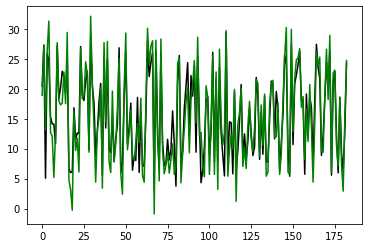

In [92]:
lm = LinearRegression() #linear regressor
lm.fit(x_train, y_train.values.ravel()) #fitting the training data to the regressor
y_pred = lm.predict(x_test)#predicting the test data via regressor
errors = abs(y_pred - y_test.values.ravel().astype('float')) #calculating the error per row
mape = 100 * (errors/(y_test.values.ravel().astype('float')))#calculating the relative error per row
accuracy = 100-np.mean(mape) #accuracy value in percentage

#printing the Mean Absolute Error of regressor on test data
print("Linear Regression Test Mean Absolute Error: ", round(mean_absolute_error(y_test, lm.predict(x_test)), 5))
#printing the Mean Squared Error of regressor on test data
print("Linear Regression Test Mean Squared Error:", round(mean_squared_error(y_test, lm.predict(x_test)), 5))
#printing the Accuracy of regressor on test data
print("Linear Regression Model Prediction Accuracy:", round(accuracy,2), "%")

#printing the the whole test and predicted data
plt.plot(y_pred, color = "black")
plt.plot(y_test.values.ravel(), color = "green")

My second model is Random Forest Regressor. I implemented the conventional Random Forest Regression with hyperparameter tuning on n_estimators, max_depth and I obtained 98.76 % of Prediction Accuracy, 2.04831 of Test Mean Absolute Error, 6.73059 of Test Mean Squared Error. You also can see the plot of the data predicted by this regressor and test set label below.



Random Forest Regressor Model Test Mean Absolute Error: 2.04831
Random Forest Regressor Model Test Mean Squared Error: 6.73059
Random Forest Regressor Model Prediction Accuracy: 98.76 %


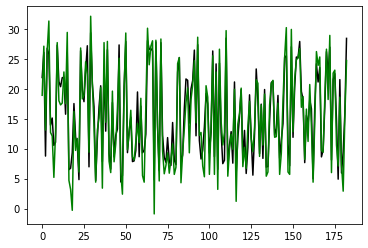

In [93]:
forest_model = RandomForestRegressor(n_estimators = 40, max_depth = 50, random_state = 42, n_jobs = -1)#random forest regressor
forest_model.fit(x_train, y_train.values.ravel())#fitting the training data to the regressor
y_pred = forest_model.predict(x_test)#predicting the test data via regressor
errors = abs(y_pred - y_test.values.ravel().astype('float'))#calculating the error per row
mape = 100 * (errors/(y_test.values.ravel().astype('float')))#calculating the relative error per row
accuracy = 100-np.mean(mape)#accuracy value in percentage

#printing the Mean Absolute Error of regressor on test data
print("Random Forest Regressor Model Test Mean Absolute Error:", round(mean_absolute_error(y_test, forest_model.predict(x_test)),5))
#printing the Mean Squared Error of regressor on test data
print("Random Forest Regressor Model Test Mean Squared Error:", round(mean_squared_error(y_test, forest_model.predict(x_test)),5))
#printing the Accuracy of regressor on test data
print("Random Forest Regressor Model Prediction Accuracy:", round(accuracy,2), "%")

#printing the the whole test and predicted data
plt.plot(y_pred, color = "black")
plt.plot(y_test.values.ravel(), color = "green")



My third model is Support Vector Regression. I implemented the conventional Support Vector Regression with hyperparameter tuning on kernel, gamma and I obtained 93.01 % of Prediction Accuracy, 2.84895 of Test Mean Absolute Error, 13.3862 of Test Mean Squared Error. You also can see the plot of the data predicted by this regressor and test set label below.



Support Vector Machine Model Test Mean Squared Error: 13.3862
Support Vector Machine Model Test Mean Absolute Error: 2.84895
Support Vector Machine Prediction Accuracy: 93.01 %


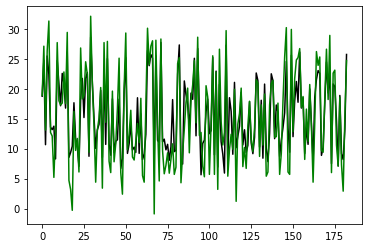

In [94]:
svr_model = make_pipeline(StandardScaler(), SVR(kernel = "rbf", gamma='auto'))
svr_model.fit(x_train, np.array(y_train).ravel())#fitting the training data to the regressor
y_pred = svr_model.predict(x_test)#predicting the test data via regressor

errors = abs(y_pred-np.array(y_test).ravel())#calculating the error per row
mape = 100 * (errors/(np.array(y_test).ravel()))#calculating the relative error per row
accuracy = 100-np.mean(mape)#accuracy value in percentage

#printing the Mean Squared Error of regressor on test data
print("Support Vector Machine Model Test Mean Squared Error:", round(mean_squared_error(y_test, svr_model.predict(x_test)),5))
#printing the Mean Absolute Error of regressor on test data
print("Support Vector Machine Model Test Mean Absolute Error:", round(mean_absolute_error(y_test, svr_model.predict(x_test)),5))
#printing the Accuracy of regressor on test data
print("Support Vector Machine Prediction Accuracy:", round(accuracy,2), "%")

#printing the the whole test and predicted data
plt.plot(y_pred, color = "black")
plt.plot(y_test.values.ravel(), color = "green")



The function below is implemented to keep one hyperparameter at a time as an independent variable and by changing its value within a specified range, one can see its optimum value for high accuracy. After selection of possibe regressor usage, I wanted to evaluate how much a regressor can deviate by changing specific parameters. I testified many different parameters using script below with slight changes.
For simplicity I will show how I kept the "max_depth" as independent variable and tried to evaluate the accuracy value for different values in a specific interval. Then, by visual inference, one can decide on how much to value a hyperparameter.

Text(0, 0.5, 'Accuracy')

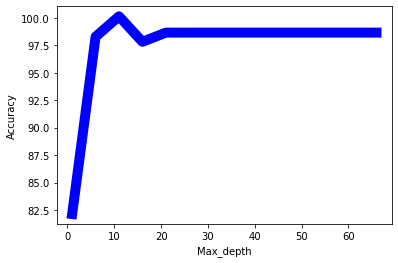

In [95]:
def hype_find(n):
    # n: hyperparameter
    
    #defining the regressor model with to start evaluation
    forest_model = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators = 40, max_depth = n, random_state = 42, n_jobs = -1),)
    forest_model.fit(x_train, y_train.values.ravel()) #fitting the data with assigned parameter and regressor
    y_pred = forest_model.predict(x_test) #making prediction with assigned parameter and regressor
    
    #same blocks calculating the accuracy
    errors = abs(y_pred - y_test.values.ravel().astype('float'))
    mape = 100 * (errors/y_test.values.ravel().astype('float'))
    accuracy = 100-np.mean(mape)
    
    return accuracy

listem = []
for i in list(np.arange(1, 70, 5, dtype=int)):
    listem.append(hype_find(i))
#plotting accuracy versus max_depth value
plt.plot(np.arange(1, 70, 5, dtype=int), listem, color = "BLUE", linewidth = 10)
plt.xlabel("Max_depth")
plt.ylabel("Accuracy")





# **_Conclusion_**

Trying out different models, three regressor types were the ones which fitted to the data in the most efficient way. After the determination of regression types, hyperparameter tuning was the next stage. 
Eventually, the results I obtained were satisfactorily succesfull. By adding more records of Madrid Weather measurements to the dataset, one can come up with a more meaniningful and robust model.